### Introduction

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data and Summary

In [106]:
# Import necessary modules.

import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from glob import glob 
%matplotlib inline

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

from tensorflow.keras.models import Sequential          # Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D              # This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D        # Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten             # Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout      # Dropout: Applies Dropout to the input.
                                                        # Dense: Just your regular densely-connected NN layer.

In [16]:
### Load Data and print the shape

In [107]:
image = np.load('/content/drive/My Drive/Great_Learning/images.npy')   

In [108]:
label = pd.read_csv('/content/drive/My Drive/Great_Learning/Labels.csv') 

In [109]:
print(image.shape)
print(label.shape)

(4750, 128, 128, 3)
(4750, 1)


In [110]:
print(label.value_counts())

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64


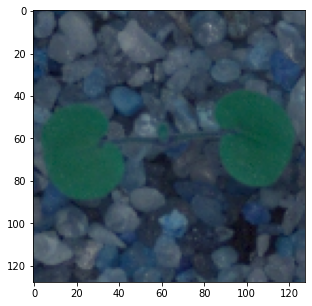

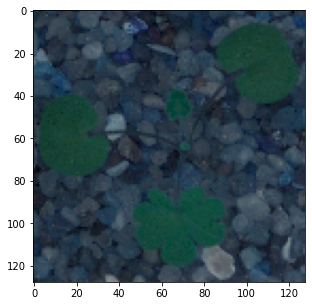

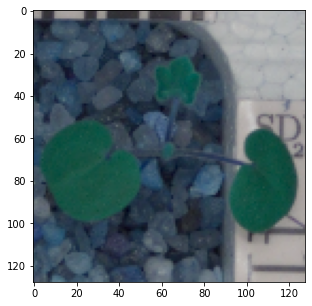

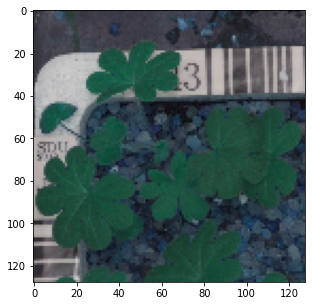

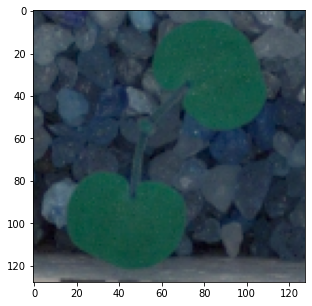

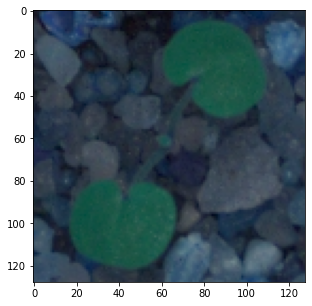

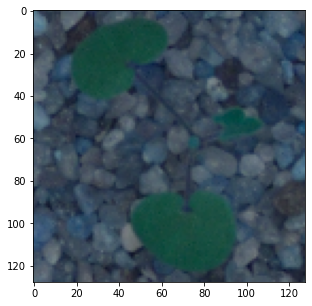

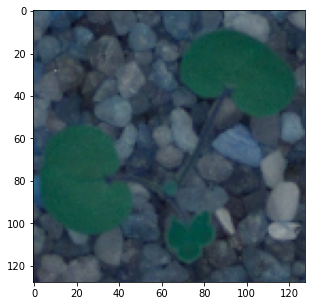

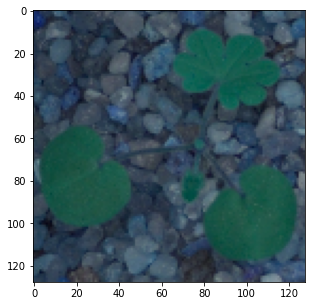

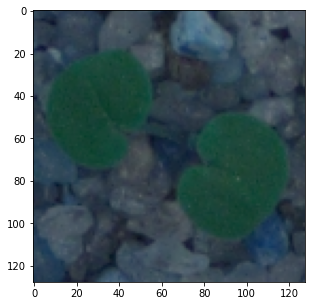

In [111]:
## Visualise images in the dataset
for i in range(10):
  plt.figure(figsize=(10,5))
  plt.imshow(image[i], cmap='gray')
  plt.show()

### Data Pre-processing

#### Normalization

In [112]:
from numpy import asarray
image2 = asarray(image)
# confirm image range is 0-255
print('Data Type: %s' % image2.dtype)
print('Min: %.3f, Max: %.3f' % (image2.min(), image2.max()))

Data Type: uint8
Min: 0.000, Max: 255.000


In [113]:
# convert from integers to floats
image2 = image2.astype('float32')
# normalize to the range 0-1
image2 /= 255.0
# confirm the normalization
print('Min: %.2f, Max: %.2f' % (image2.min(), image2.max()))

Min: 0.00, Max: 1.00


#### Gaussian Blurring

In [114]:
# Now we apply the gaussian blur to reduce the noise in the image
for idx, img in enumerate(image2):
  image2[idx] = cv2.GaussianBlur(img, (5, 5), 0)

#### After Pre-processing visualisation

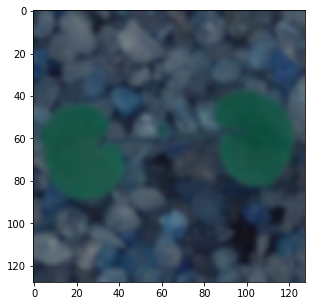

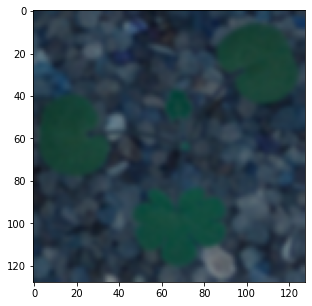

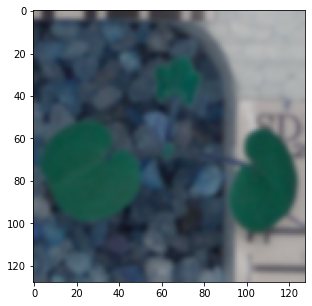

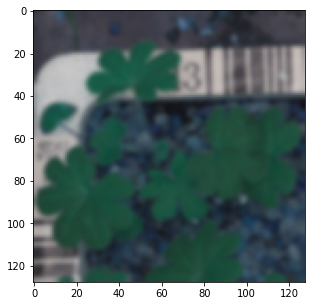

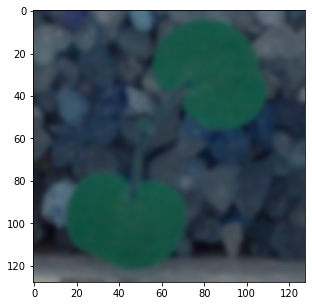

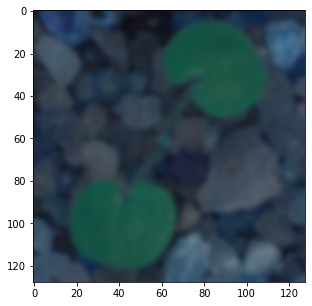

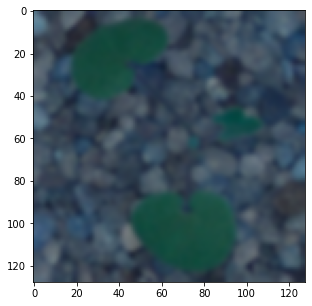

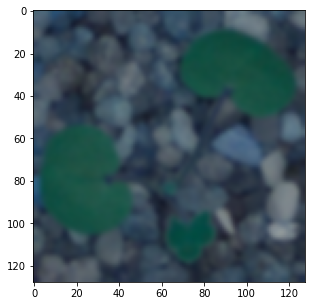

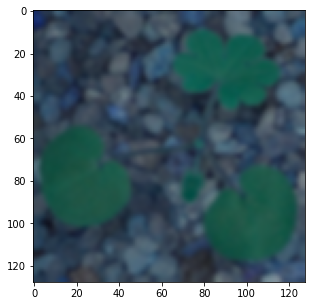

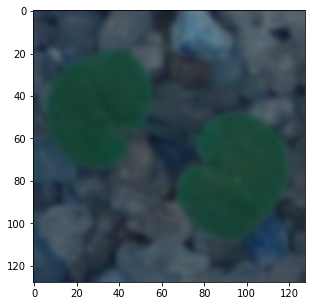

In [115]:
## Visualise images in the dataset
for i in range(10):
  plt.figure(figsize=(10,5))
  plt.imshow(image2[i], cmap='gray')
  plt.show()

### Data Compatible For Modelling

In [116]:
# Convert labels to one hot vectors.
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
label = enc.fit_transform(label)
print(label[0])

[0 0 0 0 0 0 0 0 0 0 1 0]


### Dataset Split

In [145]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(image2, label, test_size=0.30, random_state=42)

#Split Test Data into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('X_train shape is:', X_train.shape)
print('y_train shape is:', y_train.shape)
print('X_test shape is:', X_test.shape)
print('y_test shape is:', y_test.shape)
print('X_val shape is:', X_val.shape)
print('y_val shape is:', y_val.shape)

X_train shape is: (3325, 128, 128, 3)
y_train shape is: (3325, 12)
X_test shape is: (713, 128, 128, 3)
y_test shape is: (713, 12)
X_val shape is: (712, 128, 128, 3)
y_val shape is: (712, 12)


In [27]:
# the shape of the input dataset have a thrid dimension for the RGB channel and are compatible shapes for the keras model

In [118]:
print(y_train[0])

[0 0 1 0 0 0 0 0 0 0 0 0]


### Buiding CNN Model

In [119]:
from tensorflow.keras.models import Sequential          # Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D              # This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D        # Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten             # Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout      # Dropout: Applies Dropout to the input.
                                                        # Dense: Just your regular densely-connected NN layer.

In [121]:
# Set the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_16 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 64)       

In [137]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)

### Modelling and Evaluation

In [138]:
# Set the batch size, number of epochs.
batch_size = 32
num_classes = 12
epochs = 40
num_predictions = 20

In [139]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

Epoch 1/40
102/104 [============================>.] - ETA: 0s - loss: 0.4787 - accuracy: 0.8297
Epoch 00001: val_loss improved from inf to 1.47667, saving model to cifar_cnn_checkpoint_01_loss1.4767.h5
104/104 [==============================] - 3s 31ms/step - loss: 0.4790 - accuracy: 0.8298 - val_loss: 1.4767 - val_accuracy: 0.4902
Epoch 2/40
103/104 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.8434
Epoch 00002: val_loss improved from 1.47667 to 0.67912, saving model to cifar_cnn_checkpoint_02_loss0.6791.h5
104/104 [==============================] - 3s 28ms/step - loss: 0.4604 - accuracy: 0.8433 - val_loss: 0.6791 - val_accuracy: 0.7584
Epoch 3/40
103/104 [============================>.] - ETA: 0s - loss: 0.4634 - accuracy: 0.8337
Epoch 00003: val_loss did not improve from 0.67912
104/104 [==============================] - 3s 28ms/step - loss: 0.4623 - accuracy: 0.8343 - val_loss: 0.9104 - val_accuracy: 0.6685
Epoch 4/40
103/104 [============================>

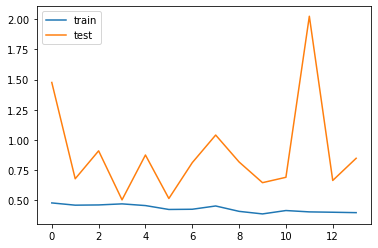

In [140]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [146]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 10ms/step - loss: 0.8080 - accuracy: 0.7363
Test loss: 0.8080074787139893
Test accuracy: 0.7363253831863403


In [147]:
y_pred = model.predict(X_test)

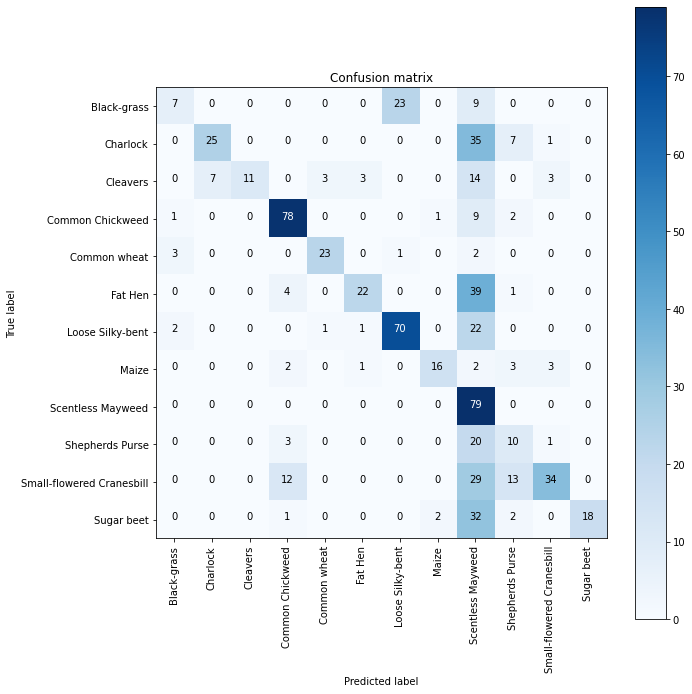

In [128]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
#y_pred = model.predict(X_test)
y_pred_Classes = np.argmax(y_pred, axis = 1) 
y_test = np.argmax(y_test, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(y_test, y_pred_Classes)

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = enc.classes_) 

### Visual Predictions

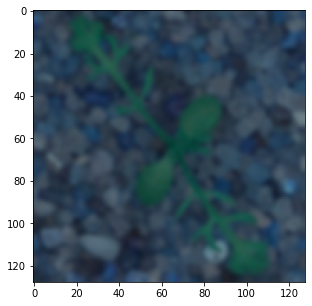

[0 0 0 0 0 0 0 0 1 0 0 0]
8


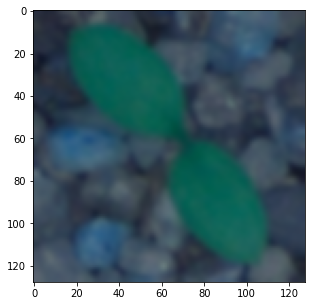

[0 0 0 1 0 0 0 0 0 0 0 0]
3


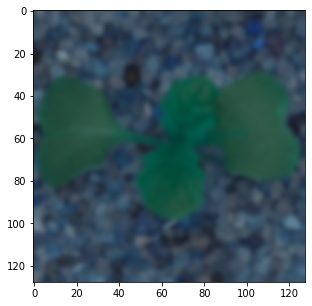

[0 1 0 0 0 0 0 0 0 0 0 0]
1


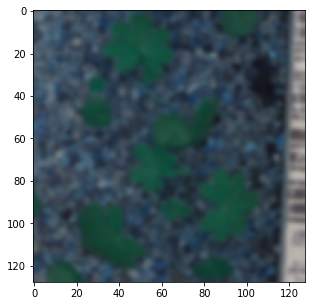

[0 0 0 0 0 0 0 0 0 0 1 0]
3


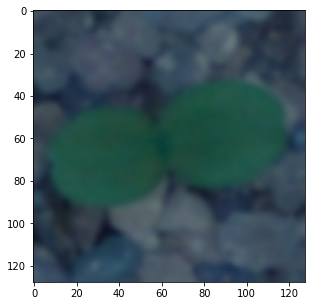

[0 0 1 0 0 0 0 0 0 0 0 0]
8


In [148]:
## Visualise specific images in the test set
for i in [2,3,33,36,59]:
  #X_test.reshape(X_test[0],128,128,3)
  X_test[i]
  plt.figure(figsize=(10,5))
  plt.imshow(X_test[i], cmap='gray')
  plt.show()
  print(y_test[i])
  print(y_pred_Classes[i])